In [9]:
from math import sqrt
from numpy import array
from scipy.optimize import fmin_l_bfgs_b
import yfinance as yf

In [7]:
def RMSE(params, *args):

    Y = args[0]
    rmse = 0

    alpha, beta, gamma = params
    m = args[1]
    a = [sum(Y[0:m]) / float(m)]
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]

    s = [Y[i] / a[0] for i in range(m)]
    y = [(a[0] + b[0]) * s[0]]

    for i in range(len(Y)):
        a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
        y.append((a[i + 1] + b[i + 1]) * s[i + 1])

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y, y[:-1])]) / len(Y))

    return rmse

In [5]:
def HoltWinters(x, m, fc, alpha = None, beta = None, gamma = None):

		Y = x[:]

		if (alpha == None or beta == None or gamma == None):
				initial_values = array([0.0, 1.0, 0.0])
				boundaries = [(0, 1), (0, 1), (0, 1)]

				parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, m), bounds = boundaries, approx_grad = True)
				alpha, beta, gamma = parameters[0]

		a = [sum(Y[0:m]) / float(m)]
		b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
		s = [Y[i] / a[0] for i in range(m)]
		y = [(a[0] + b[0]) * s[0]]
		rmse = 0

		for i in range(len(Y) + fc):
				if i == len(Y):
						Y.append((a[-1] + b[-1]) * s[-m])

				a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
				b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
				s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
				y.append((a[i + 1] + b[i + 1]) * s[i + 1])

		rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

		return Y[-fc:], alpha, beta, gamma, rmse

In [14]:
data = yf.download(['AAPL'], period='12mo')
data = data.Close
data

[*********************100%%**********************]  1 of 1 completed


Date
2023-01-10    130.729996
2023-01-11    133.490005
2023-01-12    133.410004
2023-01-13    134.759995
2023-01-17    135.940002
                 ...    
2024-01-04    181.910004
2024-01-05    181.179993
2024-01-08    185.559998
2024-01-09    185.139999
2024-01-10    184.274994
Name: Close, Length: 252, dtype: float64

In [23]:
test = data.values[:-50]

preds, alpha, beta, gamma, rmse = HoltWinters(test.tolist(), 24, 50)

In [28]:
print(f'alpha - {alpha}, beta - {beta}, gamma - {gamma}')
print(f'train rmse: {rmse}')

alpha - 1.0, beta - 0.0, gamma - 0.3424702909598319
train rmse: 3.9618733553820307


In [32]:
print(f'test rmse: {sqrt(sum([(m - n) ** 2 for m, n in zip(data.values[-50:], preds)]) / len(preds))}')

test rmse: 10.563276027276066


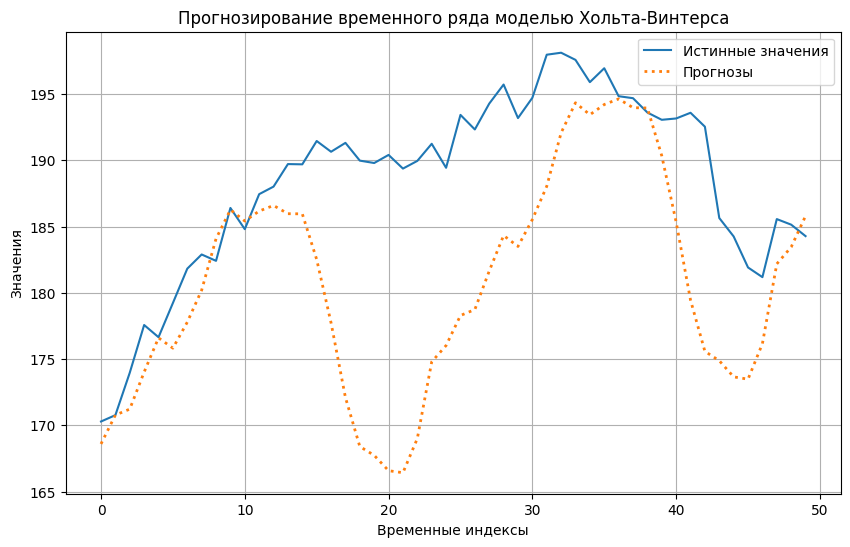

In [33]:
import matplotlib.pyplot as plt

true_values = data.values[-50:]

time_index = list(range(len(true_values)))

plt.figure(figsize=(10, 6))
plt.plot(time_index, true_values, label='Истинные значения', linestyle='-')
plt.plot(time_index, preds, label='Прогнозы', linewidth=2,linestyle=':')
plt.title('Прогнозирование временного ряда моделью Хольта-Винтерса')
plt.xlabel('Временные индексы')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()